# 1. Developing a model for classification
Data source: https://www.kaggle.com/datasnaek/league-of-legends.

In [369]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict

# sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score #
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, brier_score_loss, log_loss)
from sklearn.metrics import classification_report

games_raw = pd.read_csv('C:/Users/xsoni/Desktop/league_of_legends_ranked_games/games.csv')
#games_raw

## Data handling summary
- Removed duplicate rows, we don't want the same game to appear multiple times in our data (data collection issue?).
- Renamed team2 to team0 and changed values correspondingly for convenience.
- Kept only variables relating to team statistics to keep it simple.

In [276]:
# drop duplicate values
games_temp = games_raw.drop_duplicates()

# we keep only the variables that we want to keep for our model and encode team 1 as 1 and team 2 as 0 instead of 2
games_part1 = games_temp[['winner', 'firstBlood', 'firstTower', 'firstInhibitor'
                          , 'firstBaron' ,'firstDragon', 'firstRiftHerald']]%2

games_part2 = games_temp[['t1_towerKills', 't1_inhibitorKills', 't1_baronKills', 't1_dragonKills', 't1_riftHeraldKills'
                       ,'t2_towerKills', 't2_inhibitorKills', 't2_baronKills', 't2_dragonKills', 't2_riftHeraldKills']]

games_part2 = games_part2.rename(columns={'t2_towerKills': 't0_towerKills','t2_inhibitorKills': 't0_inhibitorKills'
                                         ,'t2_baronKills': 't0_baronKills' ,'t2_dragonKills': 't0_dragonKills'
                                         ,'t2_riftHeraldKills': 't0_riftHeraldKills'}, errors="raise")

games = pd.concat([games_part1, games_part2], axis=1)
games

,winner,firstBlood,firstTower,firstInhibitor,firstBaron,firstDragon,firstRiftHerald,t1_towerKills,t1_inhibitorKills,t1_baronKills,t1_dragonKills,t1_riftHeraldKills,t0_towerKills,t0_inhibitorKills,t0_baronKills,t0_dragonKills,t0_riftHeraldKills
0,1,0,1,1,1,1,0,11,1,2,3,0,5,0,0,1,1
1,1,1,1,1,0,1,1,10,4,0,2,1,2,0,0,0,0
2,1,0,1,1,1,0,0,8,1,1,1,0,2,0,0,1,0
3,1,1,1,1,1,1,0,9,2,1,2,0,0,0,0,0,0
4,1,0,1,1,1,1,0,9,2,1,3,0,3,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51485,0,1,0,0,0,0,0,2,0,0,0,0,10,2,0,4,0
51486,0,1,1,0,0,0,0,5,4,0,2,0,11,7,4,4,1
51487,0,0,0,0,0,1,0,0,0,0,1,0,10,2,0,2,0
51488,0,0,0,0,0,0,0,0,0,0,0,0,11,3,0,1,0


In [288]:
# the dataset is balanced, accuracy will be the go to measure for classification (also both classes are equally important)
len(games[games['winner']==1])/len(games)

0.5064736646230388

In [277]:
# train test split
X = games.drop(['winner'], axis='columns')
y = games['winner']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    shuffle=True, random_state=2) # gives us 10,2k test games

## Models that we will consider:
All three models can output probabilities for their classifications and further, all three models can be set to minimize log-loss during their fitting.

### Logistic regression (default settings except for removing intercept to avoid bias for either team)  
Pros:
- This model is included because of suspicions that the independent variables have correlation with the log odds of the target variable. 

- The data is constrained by the game mechanics which forces an absence of outliers (not investigated, based on experience), this usually improves the model performance and allows the model to generalize well to new data.

- Because of the nature of logistic regression that a small change in the independent variables causes a small and known change in the target variable, we can expect the model to estimate similarly for similar game states. Killing another tower may for example add 5% estimated probability that your team wins according to the model. The model is biased but less sensitive to small changes in the game state.

Cons:
- Multicollinearity. There does exists correlations between the "independent" variables, however, we will not investigate if this is a problem or not. The model performance may suffer from this. Although feature engineering can partly solve this issue there will always be a relationship between, for example, the number of towers killed and the number of inhibitors killed.
- We do not investigate the the relationship between the log odds and the independent variables and may therefore not act accordingly. The model performance may suffer from this. (There is great potential for improvement if this is done!)
- Can not pick up on synergistic relationships between variables.

### Decision tree and random forest (with parameters hypertuned for accuracy) 
Pros:
- In comparison to the logistic regression these models have the potential to pick up on complex relationships between the input variables and the target variable. 

- The models may also pick up synergistic relationships, such as the fact that, unless a team surrenders early, then, for a team to win it must have killed at least 5 towers and 1 inhibitor (to be able to attack the nexus). This is something that logistic regression will not be able to pick up unless included in feature engineering (this new variable would however be strongly correlated with number of towers and inhibitors killed).

- Collinearity is not a problem (which does exist).

- Because the data is constrained by the game mechanics we can expect these models to generalize well to new data.

Cons:
- More sensitive to error from difference between training data and test data (overfitting). 

### We start by hypertuning the tree models for accuracy

In [278]:
# decision tree
print('\ndecision tree: ')
dt_criterion=['log_loss','gini', 'entropy']
dt_max_depth=range(5,9,1)

dt=DecisionTreeClassifier()
dt_grid=GridSearchCV(estimator=dt,cv=10,
                                param_grid=dict(criterion=dt_criterion
                                                ,max_depth=dt_max_depth))
dt_grid.fit(X_train,y_train)
print('mean accuracy with tuned hyperparameters: ', dt_grid.best_score_)
print('tuned hyperparameters: ', dt_grid.best_params_)


# random forest
print('\nrandom forest: ')
rf_criterion=['log_loss', 'gini', 'entropy']
rf_max_depth=range(2,4,1)
rf=RandomForestClassifier()
rf_grid=GridSearchCV(estimator=rf,cv=10, 
                     param_grid=dict(n_estimators=[50] # to avoid longer runtimes
                                     , criterion=rf_criterion
                                     ,max_depth=rf_max_depth))
rf_grid.fit(X_train,y_train)
print("mean accuracy with tuned hyperparameters: ", rf_grid.best_score_)
print("tuned hyperparameters: ", rf_grid.best_params_)


decision tree: 
mean accuracy with tuned hyperparameters:  0.9683170973809487
tuned hyperparameters:  {'criterion': 'gini', 'max_depth': 8}

random forest: 
mean accuracy with tuned hyperparameters:  0.9576907224898908
tuned hyperparameters:  {'criterion': 'gini', 'max_depth': 3, 'n_estimators': 50}


## Model comparison
We will not experiment with improving the performance of the logistic regression model. However, if we were to do so, we would do it on the validation data.

In [301]:
# initiate chosen classifiers
lr = LogisticRegression(fit_intercept=False)
dt = DecisionTreeClassifier(criterion='gini',max_depth=8)
rf = RandomForestClassifier(n_estimators = 50, max_depth=3, criterion='gini')

classifier_list = [
    (lr, "Logistic Regression ")
    ,(dt, "Decision Tree")
    ,(rf, "Random Forest")
            ]
# split train into train and validation to keep test data held out until we have chosen a model, val is 16% of original
X_train_2, X_validation, y_train_2, y_validation = train_test_split(X_train, y_train, test_size=0.2, 
                                                    shuffle=True, random_state=2)

# get metrics for chosen classifiers
scores = defaultdict(list)
for i, (clf, name) in enumerate(classifier_list):
    clf.fit(X_train_2, y_train_2)
    #y_prob = clf.predict_proba(X_validation)
    y_pred = clf.predict(X_validation)
    scores["Classifier"].append(name)
    
    for metric in [accuracy_score, matthews_corrcoef]:
        score_name = metric.__name__.replace("_", " ").replace("score", "")
        scores[score_name].append(metric(y_validation, y_pred))
        
    tn, fp, fn, tp = confusion_matrix(y_validation, y_pred).ravel()
    false_negative_rate = fn / (tn + fn)
    false_positive_rate = fp / (tp + fp)
    true_negative_rate = tn / (tn + fn)
    true_positive_rate = tp / (tp + fp)
    scores['false_negative_rate'].append(false_negative_rate)
    scores['false_positive_rate'].append(false_positive_rate)
    scores['true_negative_rate'].append(true_negative_rate)
    scores['true_positive_rate '].append(true_positive_rate )

    score_df = pd.DataFrame(scores).set_index("Classifier")

score_df.round(decimals=3)

,accuracy,matthews corrcoef,false_negative_rate,false_positive_rate,true_negative_rate,true_positive_rate
Classifier,,,,,,
Logistic Regression,0.961,0.923,0.044,0.033,0.956,0.967
Decision Tree,0.965,0.931,0.039,0.030,0.961,0.970
Random Forest,0.958,0.917,0.062,0.021,0.938,0.979


### Notes:
- Accuracy is similar for all models, especially logistic regression and the decision tree, but the decision tree has the highest accuracy. It is possible that the logistic regression model would have outperformed the decision tree model in terms of accuracy had we feature engineered such that the logistic regression model could better pick up non-linear relationships which may exist between the target variable and predictor variables. Of course, the tree models hypertuning might have been subpar as well.

- Although the decision tree has higher mean accuracy than the logistic regression on the validation set, the difference may be small enough to suspect that the logistic regression would generalize better.

- One expects FNR and FPR to be close and TNR and TPR to be close as our data is balanced in terms of wins for both teams in the given data (we could have made sure it is for the training and validation data as well by using stratified cross validation). However, the random forest classifier has a bit of deviance from this, hence the lower MCC score.

- Probably most of the games that we can not classify properly are early surrenders or games where both teams have destoryed most structures.

## Test data performance
Because our goal in this step is to pick a model that performs well with respect to classifications and we have a balanced dataset, we simply go with the model that maxmimizes accuracy under validation.

In [139]:
dt = DecisionTreeClassifier(criterion='gini',max_depth=8)
dt.fit(X_train, y_train)
print(classification_report(y_test, dt.predict(X_test), digits=3))

              precision    recall  f1-score   support

           0      0.966     0.969     0.968      5038
           1      0.970     0.967     0.968      5173

    accuracy                          0.968     10211
   macro avg      0.968     0.968     0.968     10211
weighted avg      0.968     0.968     0.968     10211



The accuracy is similar as on the test data as for the mean of cross validation accuracies. The model seems to generalize well to new data.

# 2. Developing a model for probability estimates
## What is the true probability $p=P(\text{team 1 wins})$? Can it be known?  

What exactly is meant by a true probability is more of a philosphical question, but no matter what philosophical perspective we take (frequentist, randomness is lack of knowledge, degrees of belief) we still can not know the true probability. The conclusion is that an exact quanitity of a distance between the estimate $\hat{p}$ and the true probability $p$, that is, $d(p,\hat{p})$ can not be given.

We can however use heuristics by comparing estimated probabilities that the true classification, which we do know. In this section we will look at how to do this using Brier score, log-loss and calibration curves.

Let's begin by looking at probability calibration curves for the models chosen for accuracy.

## Probability calibration curves
Say our model estimates that team 1 has 80% win probability given a certain game state. If we look at the frequency of games in that game state, how often did team 1 actually win? We answer this approximately by creating bins, and looking at a frequency histogram. For each bin, say all games where the model estimates a 80-85% that team 1 wins, we look at the ratio of games where the outcome actually occured, and expect the ratio to be about 0.8-0.85 for a well calibrated model.



If we apply the same logic to all bins and then plot the ratio $\frac{\text{times team 1 won and model predicted 80-85% win probability}}{\text{#total games where model predicted 80-85% win probability}}$ against the mean predicted probability in each bin we expect to see a straight line from (0,0) to (1,1) if the model is perfectly calibrated, if not, the closer to that straight line, the better - the further away, the less reliable the model will be in making probability estimates.

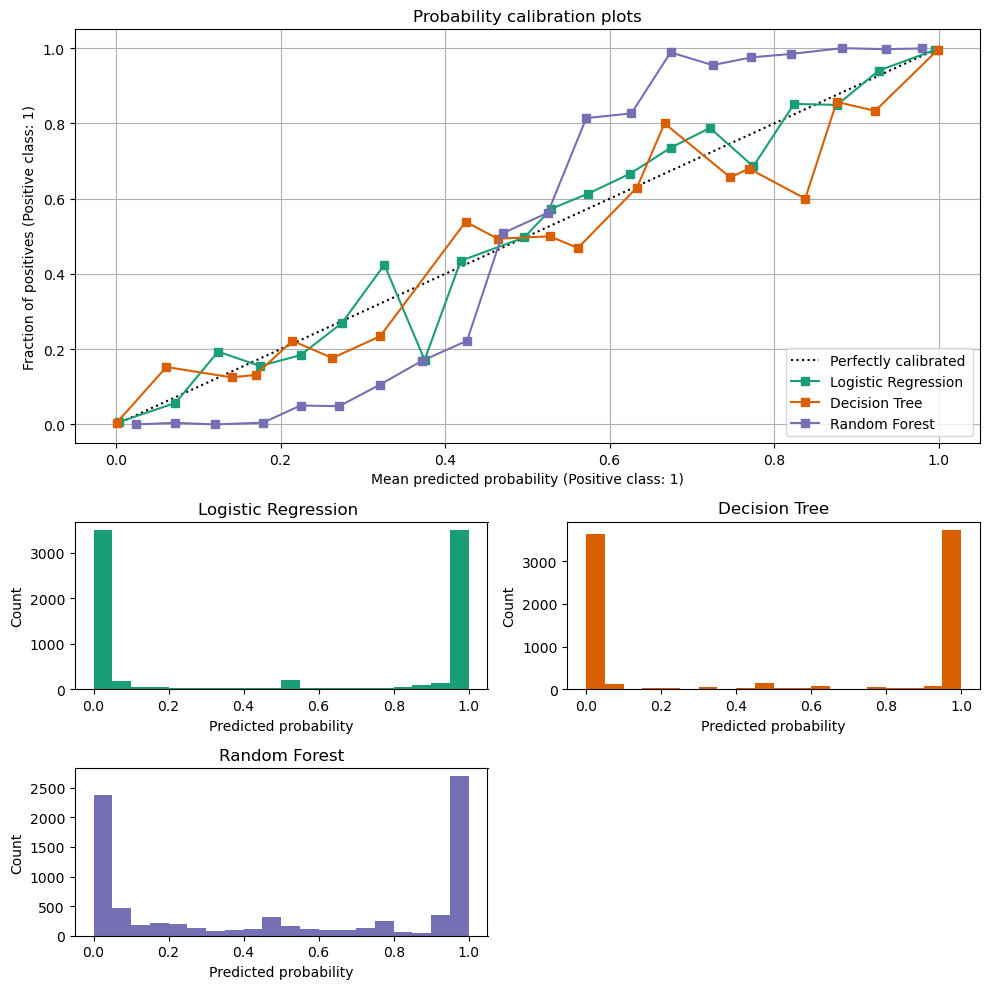

In [270]:
# initialize classifiers
log_reg = LogisticRegression(fit_intercept=False)
dt = DecisionTreeClassifier(criterion='gini',max_depth=8)
rf = RandomForestClassifier(max_depth=3, criterion='gini')

classifier_list = [
    (log_reg, "Logistic Regression ")
    ,(dt, "Decision Tree")
    ,(rf, "Random Forest")
            ]

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.cm.get_cmap("Dark2")


ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(classifier_list):
    clf.fit(X_train_2, y_train_2)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_validation,
        y_validation,
        n_bins=20,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Probability calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(classifier_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=20,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

### Notes on calibration plot
- The model model is not necesasrily bad because it deviates from the 'perfectly calibrated'-line. The reason for their squigly-ness may be due to the fact that there are few games in the 0.1-0.9 interval of predicited probabilities (seen in the histograms below) which means high variation. A solution is to use fewer and wider bins, this however does not give us as detailed information about the accuracy of the predictions. A better solution would be to keep the small bins and re-sample data from our set of games to decrease the variation in the ratio for each bin.

- The logistic regression model and decision tree model similar performance in this regard. One can expect the logistic regression model to perform quite well here because during training log-loss is minimized (as opposed to gini impurity which was optimal for the tree models for accuracy in validation!).

- The Random forest model is poorly calibrated (we can say this with more confidence as this model produces more predicted probabilities in the range 0.1-0.9 which gives the calibration curve more significance). The model seems to be too unconfident in it's classification, i.e giving for example 60% probability estimate when it ought to give about 90%. As the data comes from finished games, we expect the models to be able to be highly confident (hence also the high accuracy of all models). We see here that even if the random forest model does almost as well as the other models with respect to accuracy, it does not give good probability estimates (at least not with the given parameters).

## Log-loss vs. Brier score loss when training models to predict probabilities/odds
Log-loss is given by  
$ -\frac{1}{n} \sum_{i=1}^n y_i log(\hat{p(y_i)} + (1-y_i)log(1-\hat{p(y_i)})  $  
where $y_i$ is an indicator of team 1 winning say, and $\hat{p(y_i)}$ is the models estimate of the same. If we predict wrong we add  $y_i \hat{p(y_i)}$  or  $(1-y_i) log(1-\hat{p(y_i)}$  to the total loss depending on which mistake we made, 


Brier score is given by  
$\frac{1}{n} \sum_{i=1}^n (\hat{p}(y_i)-y_i)^2$  
which is the mean squared error between the estimated probability and the actual outcome.

Both metrics are used to calibrate corresponding curves in calibrtion plot! But in which way to the differ?

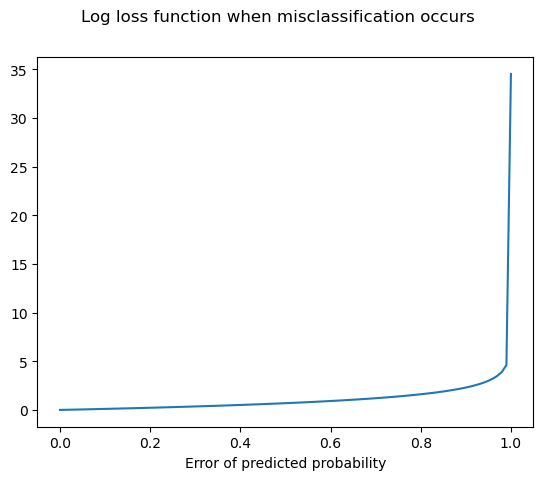

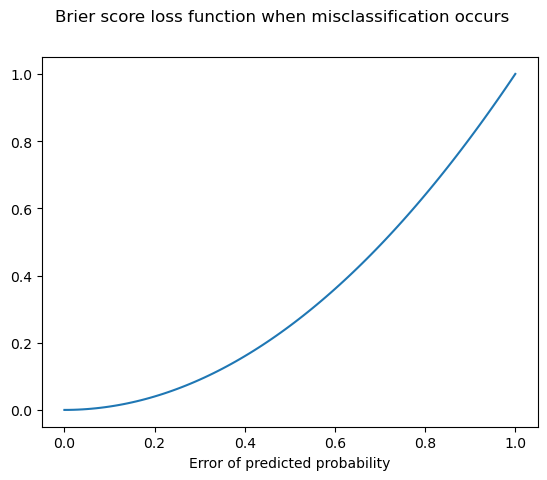

In [243]:
pred_error = [x*0.01 for x in range(0, 101)]
log_losses = [log_loss([0], [x], labels=[0,1]) for x in pred_error]
brier_score_losses = [brier_score_loss([0], [x]) for x in pred_error]

# Log loss when misclassification occurs
fig = plt.figure()
plt.plot(pred_error, log_losses)
fig.suptitle('Log loss function when misclassification occurs')
plt.xlabel('Error of predicted probability')
plt.show()

# Brier score loss when misclassification occurs
fig = plt.figure()
plt.plot(pred_error, brier_score_losses)
fig.suptitle('Brier score loss function when misclassification occurs')
plt.xlabel('Error of predicted probability')
plt.show()

- Both losses increases with the distance between the predicted probability and the true class label. If person 1 predicts that team 1 will win with 60% and person 2 does so with 80%, then person 1 is "more wrong" than person 2.

- Plot 1: Log loss gives a huge loss to predicted probabilities that are far off their true label (predicting team 1 will win with 99% probability when team 0 actually won) but small in comparison when prediciting probabilities that are more moderate (predicting team 1 will win with 60% probability when team 0 actually won). Using log loss thus teaches the model not to be overconfident in its decisions, "20 small losses might be better than 1 huge loss".

- Plot 2: Using the Brier score loss we still penalize large errors (although more gently), but we penalize medium errors far more in comparison. This will allow a model to



- The Brier score loss on the other hand is not as harsh with its loss penalty when there are larger deviances between the prediction and true class label. This loss function allows our models to admit uncertainty, effectively allowing the model to predict that games may be even - which we expect them to be if the ranking system lol uses is working!

Depending on what we want to use the model for we may use either log-loss or Brier score. We are predicting winning probabilities after the game has been played, which is an artificial situation (this is something in between prediction and inference). In this case we select Brier score loss as our benchmark as we have lots of information to make good predictions.

### We hypertune tree models to perform with respect to log loss

In [304]:
# decision tree
print('\ndecision tree: ')
dt=DecisionTreeClassifier()
dt_criterion=['log_loss','gini', 'entropy']
dt_max_depth=range(5,9,1)
dt_grid=GridSearchCV(estimator=dt,cv=10, scoring='neg_brier_score', # maximize negative score <=> minimize score
                                param_grid=dict(criterion=dt_criterion
                                                ,max_depth=dt_max_depth))
dt_grid.fit(X_train,y_train)
print('mean Brier score loss with tuned hyperparameters: ', -dt_grid.best_score_) # -score as we sklearn maximizes the negative loss
print('tuned hyperparameters: ', dt_grid.best_params_)


# random forest
print('\nrandom forest: ')
rf=RandomForestClassifier()
rf_max_depth=range(1,5,1)
rf_grid=GridSearchCV(estimator=rf,cv=10, scoring='neg_brier_score', # maximize negative score <=> minimize score
                      param_grid=dict(n_estimators=[50] # to avoid longer runtimes
                                     , criterion=rf_criterion
                                     ,max_depth=rf_max_depth))

rf_grid.fit(X_train,y_train)
print('mean Brier score loss with tuned hyperparameters: ', -rf_grid.best_score_) # -score as we sklearn maximizes the negative loss
print('tuned hyperparameters: ', rf_grid.best_params_)


decision tree: 
mean Brier score loss with tuned hyperparameters:  0.021749933415828124
tuned hyperparameters:  {'criterion': 'entropy', 'max_depth': 8}

random forest: 
mean Brier score loss with tuned hyperparameters:  0.030196656907903508
tuned hyperparameters:  {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 50}


## We compare the models

In [366]:
# initiate chosen classifiers
log_reg = LogisticRegression(fit_intercept=False)
dt = DecisionTreeClassifier(criterion='entropy',max_depth=8)
rf = RandomForestClassifier(n_estimators = 50, max_depth=4, criterion='gini')
#dt_acc = DecisionTreeClassifier(criterion='gini',max_depth=8)
#rf_acc = RandomForestClassifier(max_depth=3, criterion='gini')

classifier_list = [
    (log_reg, "Logistic Regression ")
    ,(dt, "Decision Tree (Brier)")
   # ,(dt_acc, "Decision Tree (accuracy)")
    ,(rf, "Random Forest (Brier)")
   # ,(rf_acc, "Random Forest (acc)")
    ]

# get metrics for chosen classifiers
scores = defaultdict(list)
for i, (clf, name) in enumerate(classifier_list):
    clf.fit(X_train_2, y_train_2)
    y_prob = clf.predict_proba(X_validation)
    y_pred = clf.predict(X_validation)
    scores["Classifier"].append(name)

    for metric in [brier_score_loss, log_loss]:
        score_name = metric.__name__.replace("_", " ").replace("score", "")
        scores[score_name].append(metric(y_validation, y_prob[:, 1]))
    
    for metric in [accuracy_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "")
        scores[score_name].append(metric(y_validation, y_pred))

    score_df = pd.DataFrame(scores).set_index("Classifier")

score_df.round(decimals=3)

,brier loss,log loss,accuracy
Classifier,,,
Logistic Regression,0.027,0.093,0.961
Decision Tree (Brier),0.024,0.181,0.966
Random Forest (Brier),0.032,0.118,0.961


### Notes:
- The decision tree has the lowest brier score by a little, but the logistic regression has the lowest log loss by quite a bit.
- Note that the random forest suddenly is competing about the top place in terms of accuracy and is close in terms of log loss and brier loss. The difference probably mostly comes from changes in training data during cross validation which is due to variation.

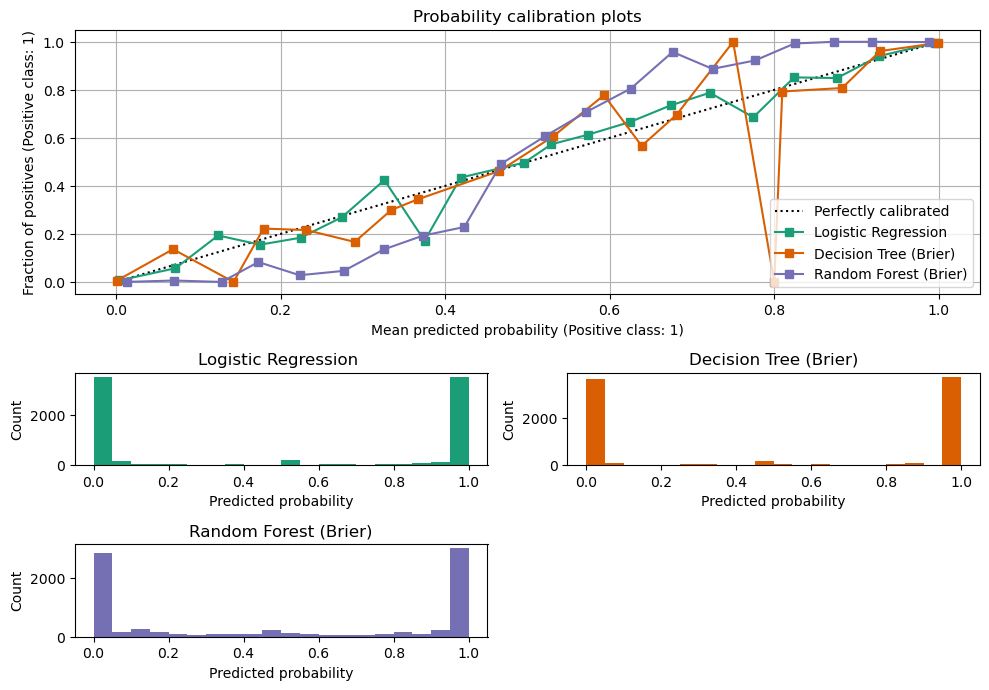

In [367]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(6, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(classifier_list):
    clf.fit(X_train_2, y_train_2)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_validation,
        y_validation,
        n_bins=20,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display
    

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Probability calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1), (4,1), (4,2)]
for i, (_, name) in enumerate(classifier_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=20,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

### Notes:
- Again, to be sure we would need to re-sample data. We see the need for this especially with the 0.75-0.80 bin for the decision tree. In the cell below we see that there are only 35 games in that bin, out of, it seems from the plot, only 0-2 were won by the positive class, team 1. This does not necessarily mean that the model performs poorly, but it is sketchy.

- The loss scores reduces a lot of information to one number. A model may for example have low log loss / Brier score if it hugs the "perfectly calibrated'-line almost everywhere, but has a large deviation for a single bin. On the other hand, the calibration plot may also be unreliable when there are few observations in a given bin as discussed before. The scores and the plot complement each other. Obs. one could build another metric based on the deviance of the calibration curve from the 'perfectly calibrated'-line (in terms of area, maximal deviation, a combination, etc).
- In the end, which model we prefer should really be determined by what the use case is. For setting odds, if the model performs strange for some interval of predicited probabilities, that may be abused by bettors.

In [368]:
# decision tree 0.75-0.80 bin count of matches
test=dt.predict_proba(X_validation)[:,0]
test=test[test>0.75]
print('Predicted probabilities of decision tree between 0.75 and 0.70: ', len(test[test<0.8]))

# logistic regression 0.75-0.80 bin count of matches for comparison
test=rf.predict_proba(X_validation)[:,0]
test=test[test>0.75]
print('Predicted probabilities of logistic regression between 0.75 and 0.70: ', len(test[test<0.8]))

Predicted probabilities of decision tree between 0.75 and 0.70:  35
Predicted probabilities of logistic regression between 0.75 and 0.70:  107


# 3. Given more time I would expand the project by looking into:

- Look into how to feature engineer and make the most out of the logistic regression model.

Looking at the correlations between independent variables and and the log odds of the empirical probability (can be estimated by binning and looking at the ratio of win/loss in each bin, for say 3-5 bins) and multicollinearity would gives an idea of how to feature engineer and hopefully allow us to deal with multicollinearity. The logistic regression model would then be useful for calculating live odds based on changes in the game.

- Champion setup for both teams and length of game:  

In my experience playing hon and dota, having more carrys in longer games tends to lead to a win.

- Different model for predicting outcome given early surrender (i.e before the pre-requiste of killing at least 5 towers and 1 inhibitor such that the nexus can be attacked)

- Try out other models after some serious data analysis (this was cut very short to focus on the second point of evaluating probability estimates).

For this is simply picked tree models and logistic regression because I have worked with them before and they came to mind.

*****************************************************************************************************************

# Test: how does the calibration curve change based on hypertuning for brier score loss or log loss for the tree models?

In [362]:
# decision tree
print('\ndecision tree: ')
dt=DecisionTreeClassifier()
dt_criterion=['log_loss','gini', 'entropy']
dt_max_depth=range(5,9,1)
dt_grid=GridSearchCV(estimator=dt,cv=10, scoring='neg_log_loss', # maximize negative score <=> minimize score
                                param_grid=dict(criterion=dt_criterion
                                                ,max_depth=dt_max_depth))
dt_grid.fit(X_train,y_train)
print('mean log loss with tuned hyperparameters: ', -dt_grid.best_score_) # -score as we sklearn maximizes the negative loss
print('tuned hyperparameters: ', dt_grid.best_params_)


# random forest
print('\nrandom forest: ')
rf=RandomForestClassifier()
rf_max_depth=range(1,5,1)
rf_grid=GridSearchCV(estimator=rf,cv=10, scoring='neg_log_loss', # maximize negative score <=> minimize score
                      param_grid=dict(n_estimators=[50] # to avoid longer runtimes
                                     , criterion=rf_criterion
                                     ,max_depth=rf_max_depth))

rf_grid.fit(X_train,y_train)
print('mean log loss with tuned hyperparameters: ', -rf_grid.best_score_) # -score as we sklearn maximizes the negative loss
print('tuned hyperparameters: ', rf_grid.best_params_)


decision tree: 
mean log loss with tuned hyperparameters:  0.08629928542082725
tuned hyperparameters:  {'criterion': 'gini', 'max_depth': 6}

random forest: 
mean log loss with tuned hyperparameters:  0.11184031784648851
tuned hyperparameters:  {'criterion': 'gini', 'max_depth': 4, 'n_estimators': 50}


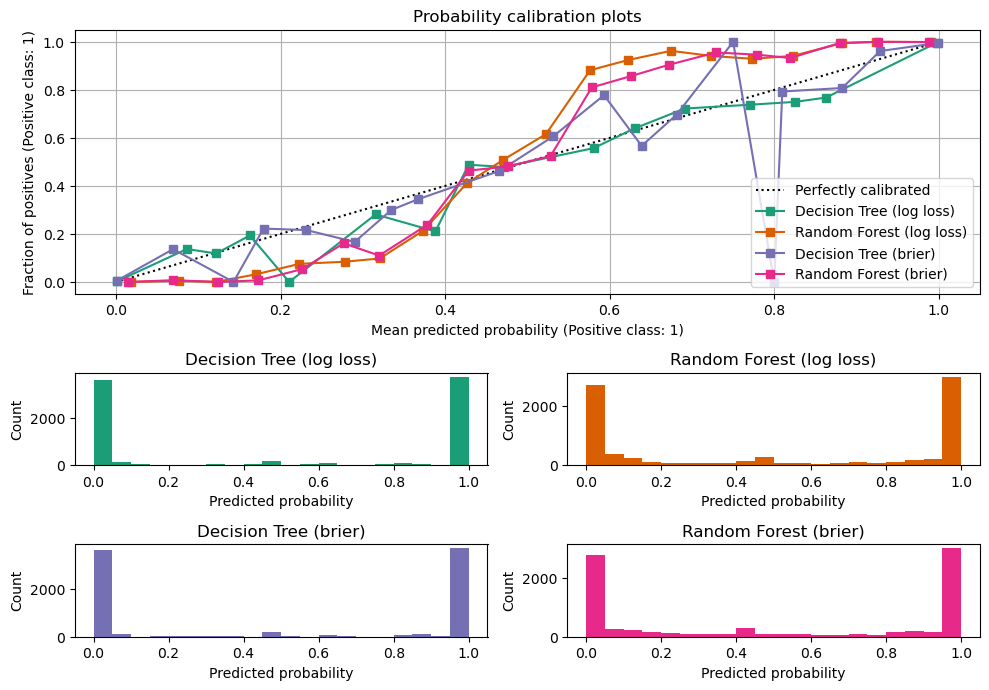

In [363]:
dt_l = DecisionTreeClassifier(criterion='gini',max_depth=6)
rf_l = RandomForestClassifier(n_estimators = 50, max_depth=4, criterion='log_loss')
dt_b = DecisionTreeClassifier(criterion='entropy',max_depth=8)
rf_b = RandomForestClassifier(n_estimators = 50, max_depth=4, criterion='gini')
    
classifier_list2 = [
    #(log_reg, "Logistic Regression "),
    (dt_l, "Decision Tree (log loss)")
   # ,(dt_acc, "Decision Tree (accuracy)")
    ,(rf_l, "Random Forest (log loss)")
   # ,(rf_acc, "Random Forest (acc)")
    ,(dt_b, "Decision Tree (brier)")
    ,(rf_b, "Random Forest (brier)")
    ]

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(6, 2)
colors = plt.cm.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(classifier_list2):
    clf.fit(X_train_2, y_train_2)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_validation,
        y_validation,
        n_bins=20,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display
    

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Probability calibration plots")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1), (4,1), (4,2)]
for i, (_, name) in enumerate(classifier_list2):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=20,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

### Number of observations in 0.1-0.9 range depending on choice of loss function for decision tree

In [364]:
# brier score loss
t1=dt_b.predict_proba(X_train_2)
t1=t1[t1>0.1]
print('Predicted probabilities between 0.1 and 0.9 with brier score loss: ', len(t1[t1<0.9])
     ,'\nout of total: ', len(X_train_2))

# log loss
t2=dt_l.predict_proba(X_train_2)
t2=t2[t2>0.1]
print('\nPredicted probabilities between 0.1 and 0.9 with log loss: ', len(t2[t2<0.9])
     ,'\nout of total: ', len(X_train_2))

Predicted probabilities between 0.1 and 0.9 with brier score loss:  5062 
out of total:  32673

Predicted probabilities between 0.1 and 0.9 with log loss:  5972 
out of total:  32673


### As expected from looking at the plot of the loss functions, the decision tree trained with Brier score loss makes more predictions that are closer to 0 or 1 estimated probability and the log loss trained model makes more cautious predictions.